## CFFI, Ctypes, Cython: The good, the bad and the ugly

## Pycon Israel 2017

## Matti Picus

![The movie poster](https://images-na.ssl-images-amazon.com/images/M/MV5BMTQxNDcyMjE4NF5BMl5BanBnXkFtZTgwNTU4ODE5MDE@._V1_.jpg)

### Why did you bother to show up? There is a lecture about Grumpy and PyPy next door

Here is what we will do

<p></p>
<details>
<summary>The ``mandel`` image (5 minutes)</summary>  
  
  - Pure python  
  - Pure C  
  - Timing it
</details>  
<p></p>
<details>
<summary>How to mix C and Python (10 minutes)</summary>  
  - Ctypes  
  - Cython  
  - CFFI
</details>  
<p></p>
<details>
<summary>Comparison - which is the good, the bad, and the ugly (10 minutes)</summary>  
  - Boilerplate  
  - Maintenance  
  - Speed
</details>  
Questions

In [1]:
from __future__ import print_function, division
%matplotlib notebook
from timeit import default_timer as timer
import numpy as np
from PIL import Image
from matplotlib.pylab import imshow, show, figure, subplots

In [2]:
# Our mission: to create a fractal image. 
# We decide to define a simple structure to hold the image: width, height, data
# and design an API where we will call a function for each pixel in the image. 
# We were taught that a function should return status, so the actual value will be returned from the function
# as a "pointer" to a value. This turns out to be  a bit awkward in python, but not unsurmountable

class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = np.empty(width*height, dtype='uint8')

def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, oneval)
            image.data[yy + x] = oneval[0]

In [3]:
def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

In [4]:
# Pure python
width = 1500
height = 1000
image = Img(width, height)
s = timer()
oneval = np.empty(1, dtype='uint32')
create_fractal(image, 20, mandel, oneval)
e = timer()
pure_python = e - s
print('pure python required {:.2f} secs'.format(pure_python))
im = Image.fromarray(image.data.reshape(height, width))
im.save('python_numpy.png')

pure python required 5.68 secs


<IPython.core.display.Javascript object>


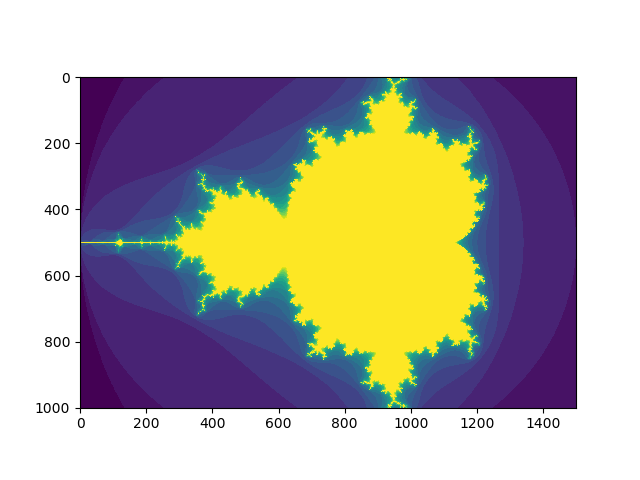

In [5]:
figure()
img = Image.open('python_numpy.png')
imshow(img); show()

In [6]:
%%bash
# EVERYONE KNOWS PYTHON IS TOO SLOW! So we outsource the whole thing to a contractor, keeping the format of
# two functions and their signatures. The contractor rewrites it in C, now the ``*val`` make sense
cat mandel.c

#include <complex.h>

int mandel(float x, float y, int max_iters, unsigned char * val)
{
    int i = 0;
    _Complex float c = CMPLX(x, y);
    _Complex float z = CMPLX(0, 0);
    for (i = 0; i < max_iters; i++)
    {
        z = z * z + c;
        if ((crealf(z) * crealf(z) + cimagf(z) * cimagf(z)) >= 4)
        {
            *val = i;
            return 0;
        }
    }
    *val = max_iters;
    return 1;
}


In [7]:
%%bash 
cat create_fractal.c

int mandel(float x, float y, int max_iters, unsigned char * val);

typedef struct _Img{
    int width;
    int height;
    unsigned char * data;
} Img;


void create_fractal(Img img,  int iters) {
    float pixel_size_x = 3.0 / img.width;
    float pixel_size_y = 2.0 / img.height;
    for (int y=0; y < img.height; y++) {
        float imag = y * pixel_size_y - 1;
        int yy = y * img.width;
        for (int x=0; x < img.width; x++) {
            float real = x * pixel_size_x - 2;
            unsigned char color;
            int ret = mandel(real, imag, iters, &color);
            img.data[yy + x] = color;
        }
    }
}


In [8]:
%%bash
# YUK - is this really what we wanted?
cat main.c

# Compile a shared object, and then compile the exe
gcc --shared -fPIC -O3 mandel.c create_fractal.c -o libcreate_fractal.so
gcc -O3 main.c -lnetpbm -L. -lcreate_fractal -o main

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

// call this function to start a nanosecond-resolution timer
struct timespec timer_start(){
    struct timespec start_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &start_time);
    return start_time;
}

// call this function to end a timer, returning nanoseconds elapsed as a long
long timer_end(struct timespec start_time){
    struct timespec end_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &end_time);
    long diffInNanos = end_time.tv_nsec - start_time.tv_nsec;
    return diffInNanos;
}

#include "create_fractal.c"

int main(int argc, const char *argv[], const char * env[])
{
    int width = 1500;
    int height = 1000;
    int iters = 20;
    FILE * fid = NULL;
    Img img;
    struct timespec vartime;
    long time_elapsed_nanos;
    img.width = width;
    img.height = height;
    size_t written;
    img.data = (unsigned char*)malloc(width * height * sizeof(unsigned char));
    if (NULL == img.data)
        return 

In [9]:
%%bash
# Run it
LD_LIBRARY_PATH=. ./main > pure_c.txt

create_fractal required 196 millisecs



<IPython.core.display.Javascript object>


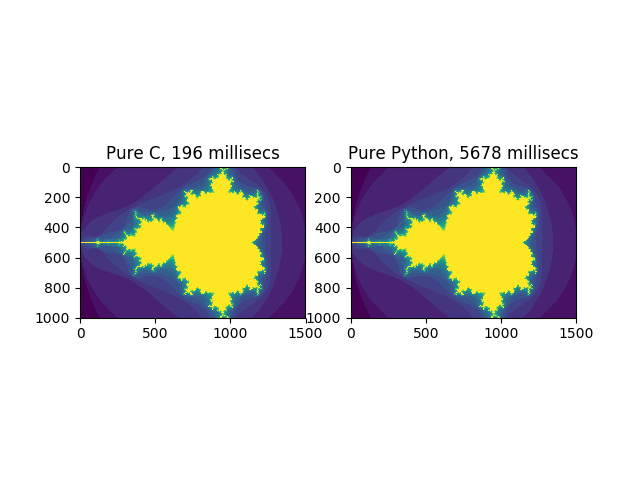

Pure python is 29.0 times slower than Pure C


In [10]:
with open('pure_c.txt') as fid:
    txt = fid.read()
    print(txt)
    pure_c = int(txt.split(' ')[2])

from matplotlib.pylab import imshow, show, figure, subplots
fig, ax = subplots(1,2)
with open('c.raw', 'rb') as fid:
    img = Image.frombytes(data=fid.read(), size=(1500,1000), mode="L")
ax[0].imshow(img); ax[0].set_title('Pure C, {:d} millisecs'.format(pure_c))
img = Image.open('python_numpy.png')
ax[1].imshow(img); ax[1].set_title('Pure Python, {:.0f} millisecs'.format(1000*pure_python))
fig.show()
print('Pure python is {:.1f} times slower than Pure C'.format(1000.0*pure_python/pure_c))

Cool. We now have  a version in pure C that runs in about 200 ms. But hang on, we wanted this to be part of a whole pipeline, where we can use and reuse the functions ``mandel`` and ``create_fractal``. Arghh, we have painted ourselves into a trap. Note that we compiled ``libcreate_fractal.so`` as a shared object, so maybe we can call it from Python?

In [11]:
#ctypes
# First all the declarations
import ctypes
import numpy as np
from timeit import default_timer as timer
from PIL import Image, ImageFilter

class CImg(ctypes.Structure):
    _fields_ = [('width', ctypes.c_int),
                ('height', ctypes.c_int),
                ('data', ctypes.POINTER(ctypes.c_uint8)),
               ]

    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Note this creates a class for each width*height value
        # but will keep the img.data alive in the interpreter
        self.data = (ctypes.c_uint8 * (width * height))() # !!!!!!

    def asmemoryview(self):
        ret = (ctypes.c_uint8 * (width * height))()
        for i in range(width*height):
            ret[i] = self.data[i]
        return memoryview(ret)

# Load the DLL
cdll = ctypes.cdll.LoadLibrary('./libcreate_fractal.so')

#Define the interfaces
create_fractal1 = cdll.create_fractal
create_fractal1.argtypes = [CImg, ctypes.c_int]

mandel1 = cdll.mandel
mandel1.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.POINTER(ctypes.c_uint8)]

In [12]:
img = CImg(width, height)

s = timer()
create_fractal1(img, 20)
e = timer()
ctypes_onecall = e - s
print('ctypes calling create_fractal required {:.2f} millisecs'.format(1000*ctypes_onecall))
im = Image.frombuffer("L", (width, height), img.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_fractal.png')
value = (ctypes.c_uint8*1)()

s = timer()
create_fractal(img, 20, mandel1, value)
e = timer()
ctypes_createfractal = e - s
print('ctypes calling mandel required {:.2f} millisecs'.format(1000*ctypes_createfractal))
im = Image.frombuffer("L", (width, height), img.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_mandel.png')

ctypes calling create_fractal required 196.46 millisecs
ctypes calling mandel required 2831.36 millisecs


<IPython.core.display.Javascript object>


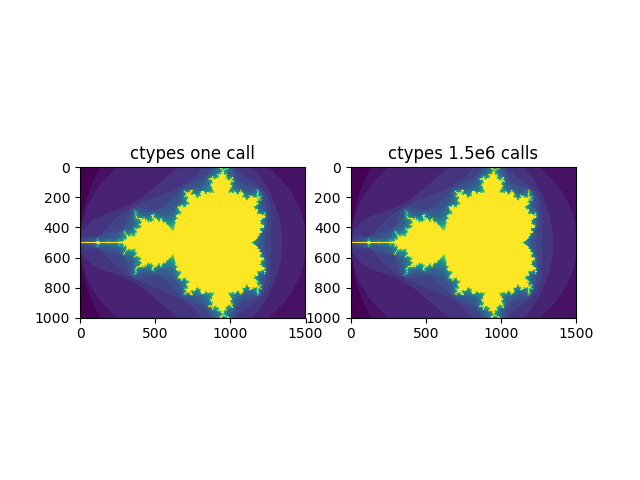

In [13]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('ctypes_fractal.png')
ctypes2 = Image.open('ctypes_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('ctypes one call')
ax[1].imshow(ctypes2); ax[1].set_title('ctypes 1.5e6 calls')
fig.show()
print ('')

In [14]:
#cffi
import cffi
ffi = cffi.FFI()
ffi.cdef('''
int mandel(float x, float y, int max_iters, uint8_t * val);

typedef struct _Img{
    int width;
    int height;
    uint8_t * data;
} Img;

void create_fractal(Img img,  int iters);
''')

dll = ffi.dlopen('./libcreate_fractal.so')

In [15]:
img = ffi.new('Img[1]')
img[0].width = width
img[0].height = height
#img[0].data = ffi.new('uint8_t[%d]' % width*height) # NO NO NO NO
# This is C - we must keep the pointer alive !!!
data1 = ffi.new('uint8_t[%d]' % (width*height,))
img[0].data = data1

s = timer()
dll.create_fractal(img[0], 20)
e = timer()
cffi_onecall = e - s
print('cffi calling create_fractal required {:.2f} millisecs'.format(1000 * cffi_onecall))

m = Image.frombuffer('L', (1500, 1000), ffi.buffer(data1), 'raw', 'L', 0, 1)
im.save('cffi_fractal.png')

data2 = ffi.new('uint8_t[%d]' % (width*height,))
img[0].data = data2
value = ffi.new('uint8_t[1]')
s = timer()
create_fractal(img[0], 20, dll.mandel, value)
e = timer()
cffi_fractal = e - s
print('cffi calling mandel required {:.2f} millisecs'.format(1000*cffi_fractal))
im = Image.frombuffer('L', (1500, 1000), ffi.buffer(data2), 'raw', 'L', 0, 1)
im.save('cffi_mandel.png')

cffi calling create_fractal required 198.29 millisecs
cffi calling mandel required 962.05 millisecs


<IPython.core.display.Javascript object>


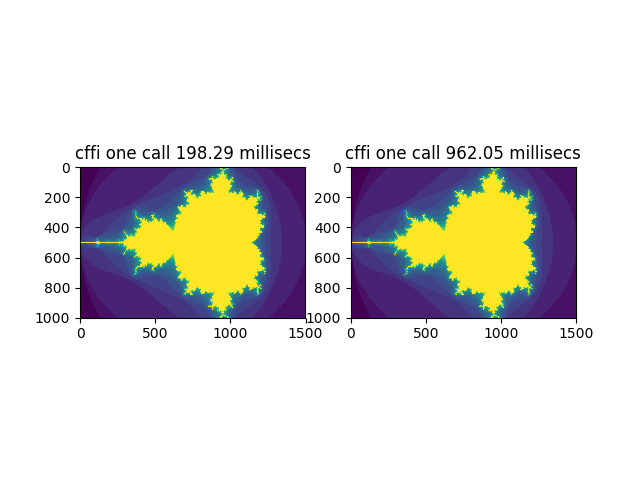

In [16]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cffi_fractal.png')
ctypes2 = Image.open('cffi_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('cffi one call {:.2f} millisecs'.format(1000*cffi_onecall))
ax[1].imshow(ctypes2); ax[1].set_title('cffi one call {:.2f} millisecs'.format(1000*cffi_fractal))
fig.show()

In [17]:
%load_ext Cython

In [18]:
%%cython -a -I. -L. -l create_fractal --link-args=-Wl,-rpath=.

cdef extern from 'create_fractal.h':
    ctypedef struct cImg:
        int width
        int height
        unsigned char * data
    
    int create_fractal(cImg img, int iters);
    int mandel(float real, float imag, int max_iters, unsigned char * val);
    
def cython_create_fractal(pyimg, iters):
    cdef cImg cimg
    cdef int citers
    cdef unsigned char[::1] tmp = pyimg.data
    
    citers = iters
    cimg.width = pyimg.width
    cimg.height = pyimg.height
    cimg.data = &tmp[0]
    return create_fractal(cimg, citers)


cpdef int cython_mandel(float real, float imag, int max_iters, unsigned char[::1] val):
    return mandel(real, imag, max_iters, &val[0])

In [19]:
# use it
image = Img(width, height)

s = timer()
cython_create_fractal(image, 20)
e = timer()
cython_onecall = e - s
print('cython onecall required {:.2f} millisecs'.format(1000*cython_onecall))
im = Image.fromarray(image.data.reshape(height, width))
im.save('cython_fractal.png')

value = np.empty(1, dtype='uint8')
s = timer()
create_fractal(image, 20, cython_mandel, value)
e = timer()
cython_fractal = e - s
print('cython many calls required {:.2f} secs'.format(cython_fractal))
im = Image.fromarray(image.data.reshape(height, width))
im.save('cython_mandel.png')

cython onecall required 197.81 millisecs
cython many calls required 1.53 secs


<IPython.core.display.Javascript object>


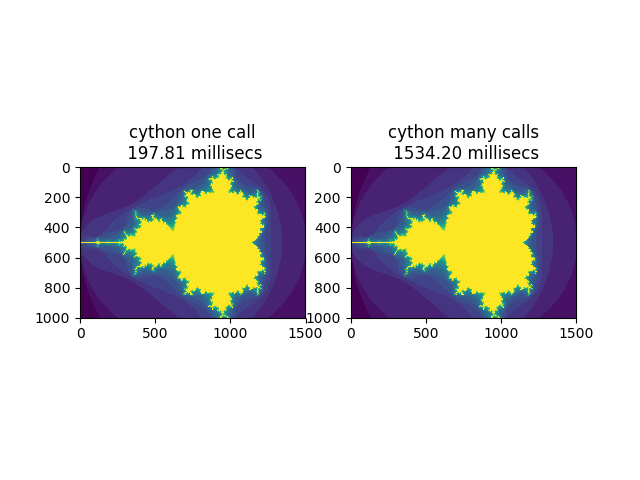

In [20]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cython_fractal.png')
ctypes2 = Image.open('cython_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('cython one call\n {:.2f} millisecs'.format(1000*cython_onecall))
ax[1].imshow(ctypes2); ax[1].set_title('cython many calls\n {:.2f} millisecs'.format(1000*cython_fractal))
fig.show()

In [21]:
# Now let's try and work out who is the good, who the bad, and who the ugly
import pprint
pprint.pprint([['      ', 'CreateFractal in Python', 'CreateFractal in C'],
              ['Python', '{:13.2f} millisecs'.format(1000*pure_python), '{:18s}'.format('')],
              ['C     ', '{:23s}'.format(''), '{:8.2f} millisecs'.format(pure_c)],
              ['ctypes', '{:13.2f} millisecs'.format(1000*ctypes_createfractal), '{:8.2f} millisecs'.format(1000*ctypes_onecall)],
              ['cffi  ', '{:13.2f} millisecs'.format(1000*cffi_fractal), '{:8.2f} millisecs'.format(1000*cffi_onecall)],
              ['cython', '{:13.2f} millisecs'.format(1000*cython_fractal), '{:8.2f} millisecs'.format(1000*cython_onecall)],
             ])

[['      ', 'CreateFractal in Python', 'CreateFractal in C'],
 ['Python', '      5678.22 millisecs', '                  '],
 ['C     ', '                       ', '  196.00 millisecs'],
 ['ctypes', '      2831.36 millisecs', '  196.46 millisecs'],
 ['cffi  ', '       962.05 millisecs', '  198.29 millisecs'],
 ['cython', '      1534.20 millisecs', '  197.81 millisecs']]


Things to think about, besides speed:

* Maintainability
* Compiler dependency
* Suseptability to bugs (object lifetimes, signature mismatches)
* Which are actively maintained

In [22]:
%%script /home/matti/pypy_stuff/pypy-latest/bin/pypy
#And for desert:
import sys
print(sys.executable)
print(sys.version)
from timeit import default_timer as timer
import cffi
from PIL import Image

ffi = cffi.FFI()

class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = ffi.new('uint8_t[%d]' % (width*height,))

def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, oneval)
            image.data[yy + x] = oneval[0]

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

# Pure python
width = 1500
height = 1000
image = Img(width, height)
s = timer()
oneval = ffi.new('uint8_t[1]')
create_fractal(image, 20, mandel, oneval)
e = timer()
pure_pypy = e - s
print('pure pypy required {:.2f} millisecs'.format(1000*pure_pypy))
im = Image.frombuffer('L', (1500, 1000), bytearray(image.data), 'raw', 'L', 0, 1)
im.save('pypyy.png')

/home/matti/pypy_stuff/pypy-latest/bin/pypy
2.7.13 (5e7bef99e9f5, May 31 2017, 22:00:12)
[PyPy 5.9.0-alpha0 with GCC 6.2.0 20160901]
pure pypy required 160.11 millisecs


<IPython.core.display.Javascript object>


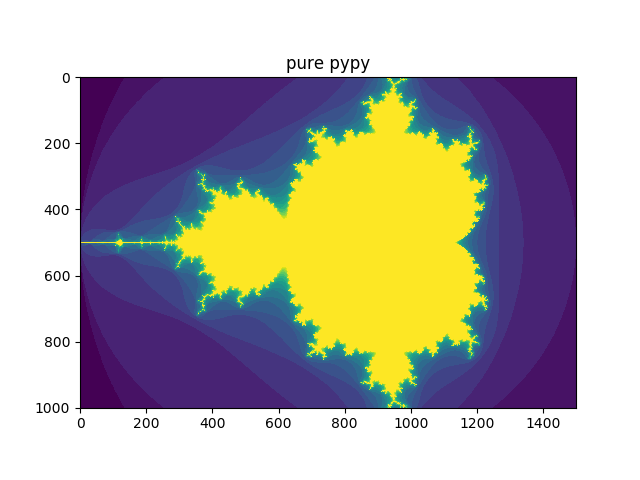

In [23]:
fig, ax = subplots(1)
ctypes1 = Image.open('pypyy.png')
ax.imshow(ctypes1); ax.set_title('pure pypy')
fig.show()